In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2


--2025-02-09 14:44:52--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-02-09 14:44:52--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  93.9MB/s    in 0.7s    

2025-02-09 14:44:53 (93.9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2025-02-09 14:45:07--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/mmod_human_face_detector.dat.bz2 [following]
--2025-02-09 14:45:07--  https://dlib.net/files/mmod_human_face_detector.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K  --.-KB/s    in 0.09s   

2025-02-09 14:45:07 (7.36 MB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



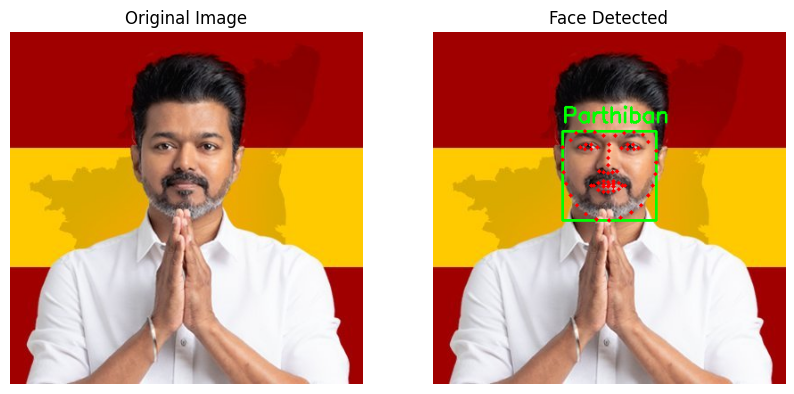

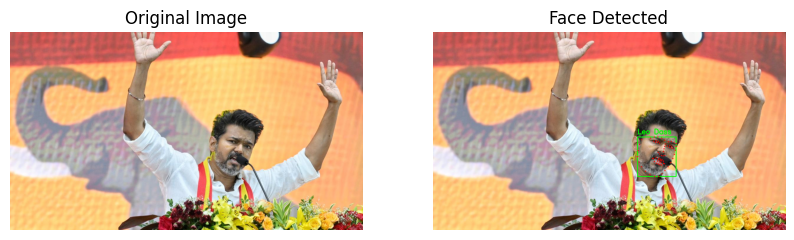

In [ ]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def get_bounding_box(landmarks):
    x_min = min(landmarks[:, 0])
    y_min = min(landmarks[:, 1])
    x_max = max(landmarks[:, 0])
    y_max = max(landmarks[:, 1])
    return (x_min, y_min, x_max, y_max)

def detect_face_and_landmarks(image_path, name="Person"):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not load image {image_path}")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    processed_image = image.copy()
    faces = detector(gray)

    for face in faces:
        landmarks = predictor(gray, face)
        points = np.array([[p.x, p.y] for p in landmarks.parts()])

        x_min, y_min, x_max, y_max = get_bounding_box(points)
        cv2.rectangle(processed_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        for (x, y) in points:
            cv2.circle(processed_image, (x, y), 2, (0, 0, 255), -1)
        cv2.putText(processed_image, name, (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    original_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

    axes[0].imshow(original_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(processed_rgb)
    axes[1].set_title("Face Detected")
    axes[1].axis("off")

    plt.show()

# Example Usage with Two Images
detect_face_and_landmarks("/content/vj.jpg", "Parthiban")
detect_face_and_landmarks("/content/parthi.jpg", "Leo Dass")


In [ ]:
# Install necessary dependencies
!pip install -q kaggle opencv-python numpy pandas tensorflow

# Upload Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset and unzip
!kaggle datasets download -d vasukipatel/face-recognition-dataset -p /content/dataset --unzip

# Import required libraries
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define paths
dataset_path = "/content/dataset/Faces/Faces"
csv_path = "/content/dataset/Dataset.csv"

# Load dataset labels from CSV
df = pd.read_csv(csv_path)
df["file_path"] = dataset_path + "/" + df["id"]  # Create full path

# Load OpenCV face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to detect faces and load images
def load_faces_and_labels(dataframe):
    images, labels = [], []
    label_map = {name: idx for idx, name in enumerate(sorted(df["label"].unique()))}

    for _, row in dataframe.iterrows():
        img_path, label = row["file_path"], row["label"]
        if not os.path.exists(img_path):
            print(f"Skipping missing file: {img_path}")
            continue

        # Read and convert to grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Skipping corrupted image: {img_path}")
            continue

        # Detect face
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        if len(faces) == 0:
            print(f"No face detected: {img_path}")
            continue

        # Crop first detected face
        x, y, w, h = faces[0]
        face_img = img[y:y+h, x:x+w]

        # Resize to 100x100
        face_img = cv2.resize(face_img, (100, 100))
        images.append(face_img)
        labels.append(label_map[label])

    if len(images) == 0:
        raise ValueError("No valid face images found!")

    return np.array(images), np.array(labels), label_map

# Load dataset
X, y, label_map = load_faces_and_labels(df)

# Normalize and reshape images
X = X.reshape(X.shape[0], 100, 100, 1) / 255.0  # Normalize pixels (0 to 1)
y = to_categorical(y, num_classes=len(label_map))  # One-hot encoding

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define CNN model
def create_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(label_map), activation='softmax')  # Output layer
    ])
    return model

# Compile and train model
model = create_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save model
model.save("/content/face_recognition_model.h5")
print("Model saved as /content/face_recognition_model.h5")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset
License(s): CC0-1.0
 99% 717M/726M [00:03<00:00, 215MB/s]
100% 726M/726M [00:03<00:00, 218MB/s]
No face detected: /content/dataset/Faces/Faces/Robert Downey Jr_87.jpg
No face detected: /content/dataset/Faces/Faces/Hrithik Roshan_35.jpg
No face detected: /content/dataset/Faces/Faces/Tom Cruise_21.jpg
No face detected: /content/dataset/Faces/Faces/Elizabeth Olsen_36.jpg
No face detected: /content/dataset/Faces/Faces/Natalie Portman_74.jpg
No face detected: /content/dataset/Faces/Faces/Priyanka Chopra_6.jpg
No face detected: /content/dataset/Faces/Faces/Zac Efron_6.jpg
No face detected: /content/dataset/Faces/Faces/Marmik_5.jpg
No face detected: /content/dataset/Faces/Faces/Claire Holt_28.jpg
No face detected: /content/dataset/Faces/Faces/Brad Pitt_85.jpg
No face detected: /content/dataset/Faces/Faces/Anushka Sharma_48.jpg
No face detected: /content/dataset/Faces/Faces/Zac E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.0545 - loss: 3.4122 - val_accuracy: 0.1635 - val_loss: 3.1894
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2379 - loss: 2.9111 - val_accuracy: 0.2776 - val_loss: 2.6666
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4685 - loss: 1.9671 - val_accuracy: 0.4221 - val_loss: 2.1348
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6368 - loss: 1.2535 - val_accuracy: 0.4943 - val_loss: 2.0275
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7694 - loss: 0.8743 - val_accuracy: 0.4943 - val_loss: 1.8657
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8520 - loss: 0.5874 - val_accuracy: 0.5703 - val_loss: 1.7114
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9122 - loss: 0.3508 - val_accuracy: 0.5932 - val_loss: 1.6801
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9664 - loss: 0.1978 - val_accuracy: 0.5779 - 

Test Accuracy: 61.60%
Model saved as /content/face_recognition_model.h5


Saving jd.jpg to jd.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


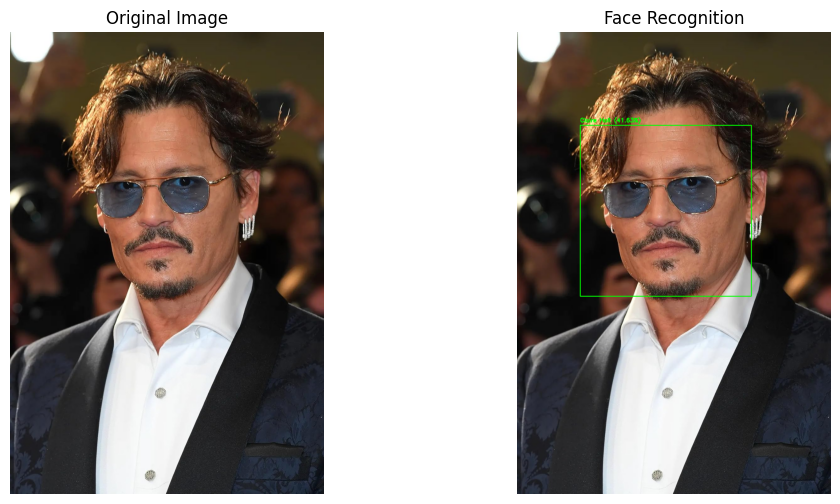

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model

# Load trained model
model_path = "/content/face_recognition_model.h5"
model = load_model(model_path)

# Load OpenCV face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Function to predict and annotate faces
def predict_faces(image_path):
    # Read original image
    img = cv2.imread(image_path)
    original_img = img.copy()  # Store a copy for side-by-side display

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
        return

    for (x, y, w, h) in faces:
        face_img = gray[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (100, 100))  # Resize to match model input
        face_img = face_img.reshape(1, 100, 100, 1) / 255.0  # Normalize

        # Predict label
        predictions = model.predict(face_img)
        label_idx = np.argmax(predictions)
        confidence = np.max(predictions)

        # Find label name from label_map
        label_name = [name for name, idx in label_map.items() if idx == label_idx][0]

        # Annotate image
        label_text = f"{label_name} ({confidence * 100:.2f}%)"
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Convert BGR to RGB for correct display in matplotlib
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display original and annotated images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_img_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(img_rgb)
    axes[1].set_title("Face Recognition")
    axes[1].axis("off")

    plt.show()

# Upload an image for testing
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Predict and annotate faces in the uploaded image
predict_faces(image_path)